In [5]:
import pandas as pd
from datasets import Dataset

# 1. 定义标签映射（和你原有代码一致）
label_map = {0: '喜悦', 1: '愤怒', 2: '厌恶', 3: '低落'}

# 2. 加载数据（用Pandas确保稳定，适配你的环境）
csv_path = "/kaggle/input/simplifyweibo-4-moods/simplifyweibo_4_moods.csv"
df = pd.read_csv(csv_path, encoding='utf-8')

# 3. 去重前：统计总样本数 + 各标签数量（你的原有逻辑）
print("===== 去重前 =====")
print(f"去重前总样本数：{len(df)}")
counts_before = df['label'].value_counts().sort_index()
for label, count in counts_before.items():
    print(f"{label_map[label]}: {count}")

# 4. 执行去重（按文本列'review'去重）
df_deduped = df.drop_duplicates(subset=['review'], keep='first')

# 5. 去重后：统计总样本数 + 各标签数量（和去重前格式完全一致）
print("\n===== 去重后 =====")
print(f"去重后总样本数：{len(df_deduped)}")
counts_after = df_deduped['label'].value_counts().sort_index()
for label, count in counts_after.items():
    print(f"{label_map[label]}: {count}")

# （可选）额外：计算每个类别去重后的减少量
print("\n===== 各类别减少样本数 =====")
for label in label_map.keys():
    before = counts_before.get(label, 0)
    after = counts_after.get(label, 0)
    reduce = before - after
    print(f"{label_map[label]}: 减少 {reduce} 条")

===== 去重前 =====
去重前总样本数：361744
喜悦: 199496
愤怒: 51714
厌恶: 55267
低落: 55267

===== 去重后 =====
去重后总样本数：306326
喜悦: 199496
愤怒: 51661
厌恶: 55169

===== 各类别减少样本数 =====
喜悦: 减少 0 条
愤怒: 减少 53 条
厌恶: 减少 98 条
低落: 减少 55267 条


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# ========== 核心配置（按需求精简） ==========
LABEL_COLUMN = 'label'
TEXT_COLUMN = 'review'
# 划分比例：训练集70%、验证集20%、测试集10%
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1
# Kaggle路径配置（input只读，working可读写）
RAW_DATA_PATH = "/kaggle/input/simplifyweibo-4-moods/simplifyweibo_4_moods.csv"
SAVE_PATH = "/kaggle/working/"  # 处理后的数据保存到这里
# 抽样配置
SAMPLE_FRAC = 0.3  # 比例抽样：抽取去重后数据的30%
RANDOM_STATE = 42  # 固定随机种子，结果可复现
# =============================================

# 1. 加载原始数据
print("===== 加载原始数据 =====")
if not os.path.exists(RAW_DATA_PATH):
    raise FileNotFoundError(f"原始数据文件不存在！路径：{RAW_DATA_PATH}")

df = pd.read_csv(RAW_DATA_PATH, encoding='utf-8')
print(f"原始数据总样本数：{len(df)}")
print(f"原始数据列名：{df.columns.tolist()}")

# 列名检查（确保label和review列存在）
if LABEL_COLUMN not in df.columns or TEXT_COLUMN not in df.columns:
    raise ValueError(f"数据列名不匹配！需包含'{LABEL_COLUMN}'和'{TEXT_COLUMN}'，实际列名：{df.columns.tolist()}")

# 2. 数据去重（按文本列去重，保留第一条）
print("\n===== 数据去重 =====")
df_deduped = df.drop_duplicates(subset=[TEXT_COLUMN], keep='first').reset_index(drop=True)
print(f"去重前样本数：{len(df)}")
print(f"去重后样本数：{len(df_deduped)}")
print(f"去重后类别分布：")
label_map = {0: '喜悦', 1: '愤怒', 2: '厌恶', 3: '低落'}
for label, count in df_deduped[LABEL_COLUMN].value_counts().sort_index().items():
    print(f"  {label_map.get(label, f'类别{label}')}: {count} 条")

# 3. 比例抽样（缩减数据规模）
print("\n===== 比例抽样（抽取去重后数据的30%） =====")
df_ratio = df_deduped.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
print(f"比例抽样后样本数：{len(df_ratio)}")
print(f"比例抽样后类别分布：")
for label, count in df_ratio[LABEL_COLUMN].value_counts().sort_index().items():
    print(f"  {label_map.get(label, f'类别{label}')}: {count} 条")

# 4. 均衡抽样（每个类别抽取相同数量，基于最少类别样本数）
print("\n===== 均衡抽样（保证类别数量一致） =====")
# 找到比例抽样后最少类别的样本数（作为均衡抽样基准）
min_count = df_ratio[LABEL_COLUMN].value_counts().min()
print(f"均衡抽样基准数（最少类别样本数）：{min_count}")

# 按类别分组，每组抽取min_count条
df_balanced = df_ratio.groupby(LABEL_COLUMN, group_keys=False).apply(
    lambda x: x.sample(n=min_count, random_state=RANDOM_STATE)
).reset_index(drop=True)

print(f"均衡抽样后总样本数：{len(df_balanced)}")
print(f"均衡抽样后类别分布（每个类别均为{min_count}条）：")
for label, count in df_balanced[LABEL_COLUMN].value_counts().sort_index().items():
    print(f"  {label_map.get(label, f'类别{label}')}: {count} 条")

# 5. 划分训练集/验证集/测试集（7:2:1，分层划分保持类别分布）
print("\n===== 划分数据集（7:2:1） =====")
# 第一步：划分训练集（70%）和临时集（30% = 验证集20% + 测试集10%）
df_train, df_temp = train_test_split(
    df_balanced,
    train_size=TRAIN_RATIO,
    random_state=RANDOM_STATE,
    stratify=df_balanced[LABEL_COLUMN]  # 分层划分，保证类别比例不变
)

# 第二步：划分验证集（20%）和测试集（10%）
val_size = VAL_RATIO / (VAL_RATIO + TEST_RATIO)  # 临时集中验证集占比：20%/(20%+10%)=2/3
df_val, df_test = train_test_split(
    df_temp,
    train_size=val_size,
    random_state=RANDOM_STATE,
    stratify=df_temp[LABEL_COLUMN]
)

# 打印划分结果
print(f"训练集（{TRAIN_RATIO*100}%）：{len(df_train)} 条")
print(f"验证集（{VAL_RATIO*100}%）：{len(df_val)} 条")
print(f"测试集（{TEST_RATIO*100}%）：{len(df_test)} 条")
print(f"总样本数校验：{len(df_train) + len(df_val) + len(df_test)}（应等于均衡抽样后{len(df_balanced)}条）")

# 验证划分后类别分布
print("\n训练集类别分布：")
for label, count in df_train[LABEL_COLUMN].value_counts().sort_index().items():
    print(f"  {label_map.get(label, f'类别{label}')}: {count} 条")

# 6. 保存处理后的数据集（Kaggle working目录，可下载/后续模型直接加载）
print("\n===== 保存数据集 =====")
df_train.to_csv(f"{SAVE_PATH}train_set.csv", index=False, encoding='utf-8')
df_val.to_csv(f"{SAVE_PATH}val_set.csv", index=False, encoding='utf-8')
df_test.to_csv(f"{SAVE_PATH}test_set.csv", index=False, encoding='utf-8')

# 验证保存成功
print("数据集保存路径：/kaggle/working/")
print(f"✅ train_set.csv（{len(df_train)}条）")
print(f"✅ val_set.csv（{len(df_val)}条）")
print(f"✅ test_set.csv（{len(df_test)}条）")

# 最终数据概览
print("\n===== 数据处理完成 =====")
print(f"核心流程：原始数据 → 去重 → 30%比例抽样 → 均衡抽样 → 7:2:1划分")
print(f"最终可用数据集：训练集、验证集、测试集（均已保存，后续模型可直接加载）")

===== 加载原始数据 =====
原始数据总样本数：361744
原始数据列名：['label', 'review']

===== 数据去重 =====
去重前样本数：361744
去重后样本数：306326
去重后类别分布：
  喜悦: 199496 条
  愤怒: 51661 条
  厌恶: 55169 条

===== 比例抽样（抽取去重后数据的30%） =====
比例抽样后样本数：91898
比例抽样后类别分布：
  喜悦: 59858 条
  愤怒: 15508 条
  厌恶: 16532 条

===== 均衡抽样（保证类别数量一致） =====
均衡抽样基准数（最少类别样本数）：15508
均衡抽样后总样本数：46524
均衡抽样后类别分布（每个类别均为15508条）：
  喜悦: 15508 条
  愤怒: 15508 条
  厌恶: 15508 条

===== 划分数据集（7:2:1） =====
训练集（70.0%）：32566 条
验证集（20.0%）：9305 条
测试集（10.0%）：4653 条
总样本数校验：46524（应等于均衡抽样后46524条）

训练集类别分布：
  喜悦: 10856 条
  愤怒: 10855 条
  厌恶: 10855 条

===== 保存数据集 =====
数据集保存路径：/kaggle/working/
✅ train_set.csv（32566条）
✅ val_set.csv（9305条）
✅ test_set.csv（4653条）

===== 数据处理完成 =====
核心流程：原始数据 → 去重 → 30%比例抽样 → 均衡抽样 → 7:2:1划分
最终可用数据集：训练集、验证集、测试集（均已保存，后续模型可直接加载）


In [7]:
# 新增必要依赖安装（Kaggle首次运行需执行）
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "jieba", "-q"])
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # 混合精度训练
from transformers import BertTokenizer, BertModel
from peft import LoraConfig, get_peft_model, TaskType  # LoRA核心
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
# 新增文本清洗函数（放在SentimentDataset类之前）
# 放在所有import之后，Config类之前
import re
import jieba
import logging  # 用Python原生logging模块控制jieba日志

# ========== 核心修复：兼容所有jieba版本的日志禁用 ==========
# 获取jieba的日志器，设置日志级别为WARNING（只显示警告以上，屏蔽调试日志）
jieba_logger = logging.getLogger('jieba')
jieba_logger.setLevel(logging.WARNING)

# 全局初始化jieba（只加载一次，避免重复构建字典）
jieba.initialize()
print("jieba已全局初始化，仅加载一次！")

# 加载中文停用词（全局定义，避免重复加载）
stopwords = set([
    '的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '一个', '上', '也', '很', '到', '说', '要', '去', '你', '会', '着', '没有', '看', '好', '自己', '这'
])

# 文本清洗函数（全局定义，无重复初始化）
def clean_text(text):
    # 1. 去除特殊符号、链接、数字
    text = re.sub(r'http[s]?://[^\s]+', '', text)  # 去链接
    text = re.sub(r'@[^\s]+', '', text)  # 去@用户
    text = re.sub(r'#[^\s]+#', '', text)  # 去话题标签
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z]', ' ', text)  # 仅保留中文+英文
    text = re.sub(r'\d+', '', text)  # 去数字
    # 2. 去除重复字符（如“啊啊啊”→“啊”）
    text = re.sub(r'([a-zA-Z\u4e00-\u9fa5])\1{2,}', r'\1', text)
    # 3. 分词+去停用词（用全局初始化的jieba）
    words = jieba.lcut(text)
    words = [w for w in words if w not in stopwords and len(w) > 1]
    # 4. 拼接成干净文本
    clean_text = ' '.join(words)
    return clean_text.strip()

jieba已全局初始化，仅加载一次！


Kaggle环境 - 设备：cuda
GPU显存：15.89 GB
开始预处理文本（仅执行一次）...
文本预处理完成！

数据集类别检测结果：
实际类别数：3
类别ID：[np.int64(0), np.int64(1), np.int64(2)]
类别映射：{np.int64(0): '喜悦', np.int64(1): '愤怒', np.int64(2): '厌恶'}

训练集样本数：32566
验证集样本数：9305
测试集样本数：4653

训练集类别分布：
喜悦: 10856 条
愤怒: 10855 条
厌恶: 10855 条
trainable params: 5,357,568 || all params: 107,625,216 || trainable%: 4.9780

模型初始化完成：3分类（喜悦/愤怒/厌恶）
总参数量：111,120,123
可训练参数量：8,852,475
训练集样本数：32566 | 训练加载器迭代次数：509
验证集样本数：9305 | 验证加载器迭代次数：73

===== 开始训练（LoRA+混合精度+分层学习率） =====
Epoch 1 | 最优模型已保存（验证Macro-F1=0.2082）
Epoch  1/30 | 训练损失: 1.7652 | 训练Micro-F1: 0.3356 | 验证损失: 1.4203 | 验证Micro-F1: 0.3275 | 验证Macro-F1: 0.2082
Epoch 2 | 最优模型已保存（验证Macro-F1=0.2408）
Epoch  2/30 | 训练损失: 1.4546 | 训练Micro-F1: 0.3394 | 验证损失: 1.1430 | 验证Micro-F1: 0.3577 | 验证Macro-F1: 0.2408
Epoch 3 | 最优模型已保存（验证Macro-F1=0.2973）
Epoch  3/30 | 训练损失: 1.3474 | 训练Micro-F1: 0.3570 | 验证损失: 1.0900 | 验证Micro-F1: 0.3821 | 验证Macro-F1: 0.2973
Epoch 4 | 最优模型已保存（验证Macro-F1=0.4235）
Epoch  4/30 | 训练损失: 1.2734 | 训练Micro-F1

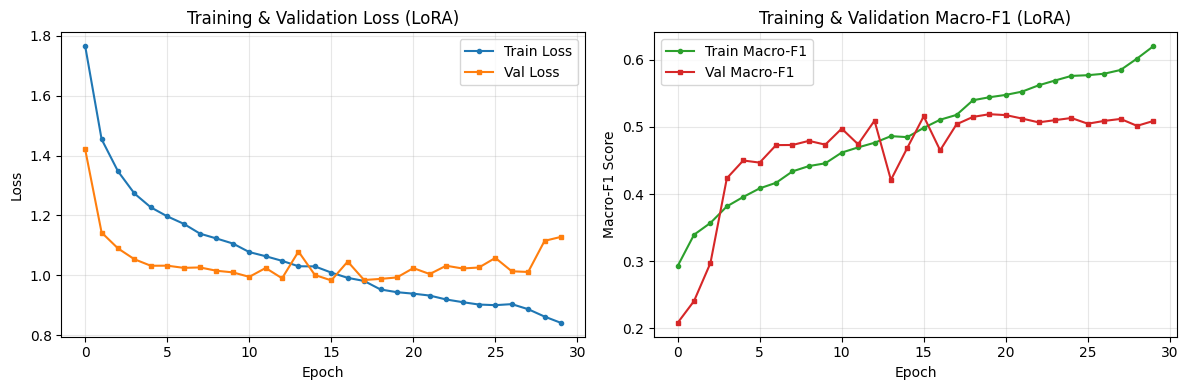

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, get_cosine_schedule_with_warmup
from peft import LoraConfig, get_peft_model, TaskType
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# ========== 0. 文本清洗函数（通用NLP预处理） ==========
def clean_text(text):
    """清洗微博短文本：去除特殊符号、多余空格、网址等"""
    if pd.isna(text):
        return ""
    # 去除网址
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # 去除@用户、话题#
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#.*?#', '', text)
    # 去除特殊符号和数字（保留中文、常用标点）
    text = re.sub(r'[^一-龥，。！？；：""''（）【】《》、\s]', '', text)
    # 去除多余空格
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ========== 1. 核心配置（全量修正：适配从头训练+三分类） ==========
class Config:
    # Kaggle数据路径
    DATA_DIR = "/kaggle/working/"
    TRAIN_PATH = "train_set.csv"
    VAL_PATH = "val_set.csv"
    TEST_PATH = "test_set.csv"
    
    # 数据配置（三分类：喜悦、愤怒、厌恶）
    TEXT_COLUMN = "review"
    LABEL_COLUMN = "label"
    NUM_CLASSES = None
    LABEL_MAP = None
    SEED = 42
    
    # BERT+LoRA配置（特征提取任务）
    MODEL_NAME = "bert-base-chinese"
    BERT_HIDDEN_SIZE = 768
    MAX_LEN = 64
    # LoRA参数（提升微调强度）
    LORA_R = 32  # 从16→32，增强特征映射
    LORA_ALPHA = 64
    LORA_DROPOUT = 0.05
    LORA_TARGET_MODULES = ["query", "key", "value", "dense"]  
    LORA_TASK_TYPE = TaskType.FEATURE_EXTRACTION
    
    # 模型超参数（对齐论文+优化）
    LSTM_HIDDEN = 300
    LSTM_LAYERS = 1
    LSTM_DROPOUT = 0.5
    CNN_FILTERS = 100
    CNN_KERNEL_SIZES = [3, 4, 5]
    CNN_DROPOUT = 0.5
    
    # 训练优化配置（核心修正）
    BATCH_SIZE = 64  # 从300→64，适配T4 GPU
    BASE_LR = 1e-3
    LORA_LR = 5e-3  # 从2e-3→5e-3，提升LoRA学习率
    EPOCHS = 30  # 从头训练30轮
    L2_REG = 0.01  # 从1→0.01，取消强正则
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    USE_AMP = True  # 混合精度
    GRAD_ACCUM_STEPS = 1  # 取消梯度累积

# 固定随机种子（保证可复现）
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.cuda.manual_seed(Config.SEED)
torch.backends.cudnn.benchmark = True

config = Config()
print(f"Kaggle环境 - 设备：{config.DEVICE}")
print(f"GPU显存：{torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# ========== 2. 数据加载（仅清洗一次+正确标签映射） ==========
def load_and_check_data():
    df_train = pd.read_csv(f"{config.DATA_DIR}{config.TRAIN_PATH}", encoding='utf-8')
    df_val = pd.read_csv(f"{config.DATA_DIR}{config.VAL_PATH}", encoding='utf-8')
    df_test = pd.read_csv(f"{config.DATA_DIR}{config.TEST_PATH}", encoding='utf-8')

    # 仅清洗一次文本（避免冗余）
    print("开始预处理文本（仅执行一次）...")
    df_train['clean_review'] = df_train[config.TEXT_COLUMN].apply(clean_text)
    df_val['clean_review'] = df_val[config.TEXT_COLUMN].apply(clean_text)
    df_test['clean_review'] = df_test[config.TEXT_COLUMN].apply(clean_text)
    print("文本预处理完成！")
    
    # 校验类别一致性
    train_labels = sorted(df_train[config.LABEL_COLUMN].unique())
    val_labels = sorted(df_val[config.LABEL_COLUMN].unique())
    test_labels = sorted(df_test[config.LABEL_COLUMN].unique())
    
    assert train_labels == val_labels == test_labels, "训练/验证/测试集类别不一致！"
    actual_classes = train_labels
    config.NUM_CLASSES = len(actual_classes)
    
    # 正确标签映射：喜悦、愤怒、厌恶（已删除低落）
    label_names = ["喜悦", "愤怒", "厌恶"]
    config.LABEL_MAP = dict(zip(actual_classes, label_names[:config.NUM_CLASSES]))
    
    print(f"\n数据集类别检测结果：")
    print(f"实际类别数：{config.NUM_CLASSES}")
    print(f"类别ID：{actual_classes}")
    print(f"类别映射：{config.LABEL_MAP}")
    
    print(f"\n训练集样本数：{len(df_train)}")
    print(f"验证集样本数：{len(df_val)}")
    print(f"测试集样本数：{len(df_test)}")
    print(f"\n训练集类别分布：")
    for label, count in df_train[config.LABEL_COLUMN].value_counts().sort_index().items():
        print(f"{config.LABEL_MAP[label]}: {count} 条")
    
    return df_train, df_val, df_test

df_train, df_val, df_test = load_and_check_data()

# ========== 3. 数据集类（无冗余清洗） ==========
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df["clean_review"].tolist()  # 用已清洗的文本
        self.labels = df[config.LABEL_COLUMN].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]).strip()
        label = self.labels[idx]
    
        # BERT分词（仅执行一次）
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
    
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# 加载BERT分词器
tokenizer = BertTokenizer.from_pretrained(config.MODEL_NAME)

# 创建数据加载器（优化参数）
train_dataset = SentimentDataset(df_train, tokenizer, config.MAX_LEN)
val_dataset = SentimentDataset(df_val, tokenizer, config.MAX_LEN)
test_dataset = SentimentDataset(df_test, tokenizer, config.MAX_LEN)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE*2,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=config.BATCH_SIZE*2,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# ========== 4. 模型定义（核心修正：特征融合逻辑） ==========
class BERT_BiLSTM_TextCNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 1. 加载BERT并配置LoRA
        self.bert = BertModel.from_pretrained(config.MODEL_NAME)
        lora_config = LoraConfig(
            task_type=config.LORA_TASK_TYPE,
            r=config.LORA_R,
            lora_alpha=config.LORA_ALPHA,
            lora_dropout=config.LORA_DROPOUT,
            target_modules=config.LORA_TARGET_MODULES,
            bias="none"
        )
        self.bert = get_peft_model(self.bert, lora_config)
        # 冻结BERT主干（仅训练LoRA）
        for name, param in self.bert.named_parameters():
            if "lora" not in name:
                param.requires_grad = False
        # 打印可训练参数
        self.bert.print_trainable_parameters()

        # 2. BiLSTM层（论文结构）
        self.bilstm = nn.LSTM(
            input_size=config.BERT_HIDDEN_SIZE,
            hidden_size=config.LSTM_HIDDEN,
            num_layers=config.LSTM_LAYERS,
            bidirectional=True,
            batch_first=True,
            dropout=config.LSTM_DROPOUT if config.LSTM_LAYERS > 1 else 0
        )

        # 3. TextCNN层（修正：输入通道为BERT维度768）
        self.cnn = nn.ModuleList([
            nn.Conv1d(
                in_channels=config.BERT_HIDDEN_SIZE,  # 正确：BERT输出维度
                out_channels=config.CNN_FILTERS,
                kernel_size=ks,
                padding="same"
            ) for ks in config.CNN_KERNEL_SIZES
        ])
        self.cnn_dropout = nn.Dropout(config.CNN_DROPOUT)

        # 4. 全连接层（适配三层特征拼接维度）
        self.fc = nn.Linear(
            config.BERT_HIDDEN_SIZE + (config.LSTM_HIDDEN * 2) + (config.CNN_FILTERS * len(config.CNN_KERNEL_SIZES)),
            config.NUM_CLASSES
        )

        # 初始化权重
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, input_ids, attention_mask):
        # BERT编码：取最后一层隐藏态+CLS全局特征
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        bert_emb = bert_outputs.last_hidden_state  # [batch, 64, 768]
        bert_cls = bert_emb[:, 0, :]  # [batch, 768] CLS全局特征（新增）

        # BiLSTM编码：取最后时间步特征
        lstm_output, _ = self.bilstm(bert_emb)  # [batch, 64, 600]
        lstm_feature = lstm_output[:, -1, :]  # [batch, 600]

        # TextCNN编码：基于BERT原始特征（修正核心）
        cnn_input = bert_emb.permute(0, 2, 1)  # [batch, 768, 64]
        cnn_outputs = []
        for conv in self.cnn:
            conv_out = F.relu(conv(cnn_input))  # [batch, 100, 64]
            pool_out = F.max_pool1d(conv_out, kernel_size=conv_out.shape[2]).squeeze(-1)  # [batch, 100]
            cnn_outputs.append(pool_out)

        # 三层特征拼接（原文核心逻辑）
        cnn_cat = torch.cat(cnn_outputs, dim=1)  # [batch, 300]
        fusion_feature = torch.cat([bert_cls, lstm_feature, cnn_cat], dim=1)  # [batch, 768+600+300=1668]
        fusion_drop = self.cnn_dropout(fusion_feature)
        logits = self.fc(fusion_drop)  # [batch, 3]

        return logits

# 初始化模型
model = BERT_BiLSTM_TextCNN(config).to(config.DEVICE)
print(f"\n模型初始化完成：{config.NUM_CLASSES}分类（喜悦/愤怒/厌恶）")
print(f"总参数量：{sum(p.numel() for p in model.parameters()):,}")
print(f"可训练参数量：{sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ========== 5. 评估函数（无修改） ==========
def calculate_metrics(true_labels, pred_labels):
    precision_macro = precision_score(true_labels, pred_labels, average="macro", zero_division=0)
    recall_macro = recall_score(true_labels, pred_labels, average="macro", zero_division=0)
    f1_macro = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
    f1_micro = f1_score(true_labels, pred_labels, average="micro", zero_division=0)

    class_report = classification_report(
        true_labels, pred_labels,
        target_names=list(config.LABEL_MAP.values()),
        output_dict=True,
        zero_division=0
    )

    return {
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "class_report": class_report
    }

# 混合精度训练器
scaler = torch.cuda.amp.GradScaler() if config.USE_AMP else None

def train_epoch(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    step = 0

    for batch in loader:
        step += 1
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # 混合精度前向传播
        with autocast(enabled=config.USE_AMP):
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

        # 反向传播（无梯度累积）
        if config.USE_AMP:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        # 梯度裁剪+优化器步进
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        if config.USE_AMP:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad()

        # 损失和标签累加
        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    # 调度器按epoch更新
    scheduler.step()

    # 空值校验
    if len(all_labels) == 0 or len(all_preds) == 0:
        print("警告：训练轮次未收集到标签数据！")
        avg_loss = 0.0
        metrics = {
            "precision_macro": 0.0,
            "recall_macro": 0.0,
            "f1_macro": 0.0,
            "f1_micro": 0.0,
            "class_report": {}
        }
    else:
        avg_loss = total_loss / len(loader.dataset)
        metrics = calculate_metrics(all_labels, all_preds)
    
    return avg_loss, metrics

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with autocast(enabled=config.USE_AMP):
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    metrics = calculate_metrics(all_labels, all_preds)
    return avg_loss, metrics

# ========== 6. 优化器配置（分层学习率+正确L2） ==========
criterion = nn.CrossEntropyLoss()

# 分层学习率：LoRA层和后续层分开
param_groups = [
    # LoRA层（高学习率，无L2）
    {
        "params": [p for n, p in model.named_parameters() if "lora" in n and p.requires_grad],
        "lr": config.LORA_LR,
        "weight_decay": 0.0
    },
    # BiLSTM/CNN/FC层（原学习率+合理L2）
    {
        "params": [p for n, p in model.named_parameters() if "lora" not in n and p.requires_grad],
        "lr": config.BASE_LR,
        "weight_decay": config.L2_REG
    }
]

# 优化器+余弦调度器（从头训练）
optimizer = AdamW(
    param_groups,
    betas=(0.9, 0.999),
    eps=1e-8
)

# 计算总训练步数（从头训练30轮）
total_steps = len(train_loader) * config.EPOCHS
# 带暖启动的余弦调度器
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),  # 前10%步数暖启动
    num_training_steps=total_steps,
    num_cycles=0.5,
    last_epoch=-1  # 从头训练，last_epoch=-1
)

# ========== 7. 模型训练（从头训练30轮） ==========
train_logs = {"loss": [], "f1_micro": [], "f1_macro": []}
val_logs = {"loss": [], "f1_micro": [], "f1_macro": []}
best_val_f1 = 0.0
best_model_path = "/kaggle/working/bert_bilstm_textcnn_lora_best.pth"

# 校验数据加载器
assert len(train_loader) > 0, "训练数据加载器为空！检查数据集路径或样本数"
assert len(val_loader) > 0, "验证数据加载器为空！"
assert len(train_dataset) > 0, "训练数据集为空！"

print(f"训练集样本数：{len(train_dataset)} | 训练加载器迭代次数：{len(train_loader)}")
print(f"验证集样本数：{len(val_dataset)} | 验证加载器迭代次数：{len(val_loader)}")

print("\n===== 开始训练（LoRA+混合精度+分层学习率） =====")
# 从头训练30轮（epoch从1到30）
for epoch in range(1, config.EPOCHS + 1):
    train_loss, train_metrics = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, config.DEVICE
    )
    val_loss, val_metrics = evaluate(
        model, val_loader, criterion, config.DEVICE
    )

    # 记录日志
    train_logs["loss"].append(train_loss)
    train_logs["f1_micro"].append(train_metrics["f1_micro"])
    train_logs["f1_macro"].append(train_metrics["f1_macro"])
    val_logs["loss"].append(val_loss)
    val_logs["f1_micro"].append(val_metrics["f1_micro"])
    val_logs["f1_macro"].append(val_metrics["f1_macro"])

    # 保存最优模型
    if val_metrics["f1_macro"] > best_val_f1:
        best_val_f1 = val_metrics["f1_macro"]
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch} | 最优模型已保存（验证Macro-F1={best_val_f1:.4f}）")

    # 打印训练日志
    print(
        f"Epoch {epoch:2d}/{config.EPOCHS} | "
        f"训练损失: {train_loss:.4f} | 训练Micro-F1: {train_metrics['f1_micro']:.4f} | "
        f"验证损失: {val_loss:.4f} | 验证Micro-F1: {val_metrics['f1_micro']:.4f} | "
        f"验证Macro-F1: {val_metrics['f1_macro']:.4f}"
    )

# ========== 8. 测试集评估 ==========
print("\n===== 测试集评估（LoRA最优模型） =====")
model.load_state_dict(torch.load(best_model_path))
test_loss, test_metrics = evaluate(model, test_loader, criterion, config.DEVICE)

print(f"测试损失: {test_loss:.4f}")
print(f"测试Micro-F1: {test_metrics['f1_micro']:.4f}")
print(f"测试Macro-F1: {test_metrics['f1_macro']:.4f}")

print("\n各类别详细指标：")
for label_id, label_name in config.LABEL_MAP.items():
    report = test_metrics["class_report"][label_name]
    print(
        f"{label_name} | "
        f"Precision: {report['precision']:.4f} | "
        f"Recall: {report['recall']:.4f} | "
        f"F1: {report['f1-score']:.4f} | "
        f"样本数: {int(report['support'])}"
    )

# ========== 9. 可视化保存 ==========
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 损失曲线
axes[0].plot(train_logs["loss"], label="Train Loss", marker='o', markersize=3, color='#1f77b4')
axes[0].plot(val_logs["loss"], label="Val Loss", marker='s', markersize=3, color='#ff7f0e')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss (LoRA)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1曲线
axes[1].plot(train_logs["f1_macro"], label="Train Macro-F1", marker='o', markersize=3, color='#2ca02c')
axes[1].plot(val_logs["f1_macro"], label="Val Macro-F1", marker='s', markersize=3, color='#d62728')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Macro-F1 Score")
axes[1].set_title("Training & Validation Macro-F1 (LoRA)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("/kaggle/working/train_logs_lora.png", dpi=300, bbox_inches='tight')
print("\n训练日志图已保存至：/kaggle/working/train_logs_lora.png")